In [11]:
import pypsa, numpy as np
import os
import pandas as pd
import csv
import matplotlib.pyplot as plt
import highspy

Several Eastern Caribbean countries with  storage and links, one year of hourly periods, with varying loads and generation from VRE 



In [12]:
#choose the working folders for reading in data and for saving output and figures
csv_folder_name =  "Eastern_CaribbeanExtendableLinksStorage/"
network = pypsa.Network(csv_folder_name)
scenario = "LimitedLinks_6hr-Storage_SKN-ATG-link_VRE-min-red_geo-min_high-link-cost/"

INFO:pypsa.components:Applying weightings to all columns of `snapshot_weightings`
INFO:pypsa.io:Imported network Eastern_CaribbeanExtendableLinksStorage has buses, generators, links, loads, storage_units


In [13]:
#specify use of linopy and solver of choice
network.optimize(solver_name="highs")

Index(['SaintKittsNevis', 'Antigua', 'Guadeloupe', 'Montserrat', 'Dominica',
       'Martinique', 'SaintLucia', 'Barbados', 'SaintVincentGrenadines',
       'Grenada'],
      dtype='object', name='Bus')
Index(['SKN MSR link', 'MSR ATG link', 'ATG GLP link', 'GLP DMA link',
       'DMA MTQ link', 'MTQ LCA link', 'LCA SVG link', 'SVG GRD link',
       'SVG BRB link', 'LCA BRB link', 'SKN ATG link'],
      dtype='object', name='Link')
Index(['SaintKittsNevis', 'Antigua', 'Guadeloupe', 'Montserrat', 'Dominica',
       'Martinique', 'SaintLucia', 'Barbados', 'SaintVincentGrenadines',
       'Grenada'],
      dtype='object', name='Bus')
Index(['SKN MSR link', 'MSR ATG link', 'ATG GLP link', 'GLP DMA link',
       'DMA MTQ link', 'MTQ LCA link', 'LCA SVG link', 'SVG GRD link',
       'SVG BRB link', 'LCA BRB link', 'SKN ATG link'],
      dtype='object', name='Link')
INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████

('ok', 'optimal')

In [14]:
#specify folder for saving results, plots
pypsa.Network.export_to_csv_folder(network,scenario)

INFO:pypsa.io:Exported network '<unnamed>' contains: generators, loads, storage_units, buses, links


<Axes: xlabel='snapshot'>

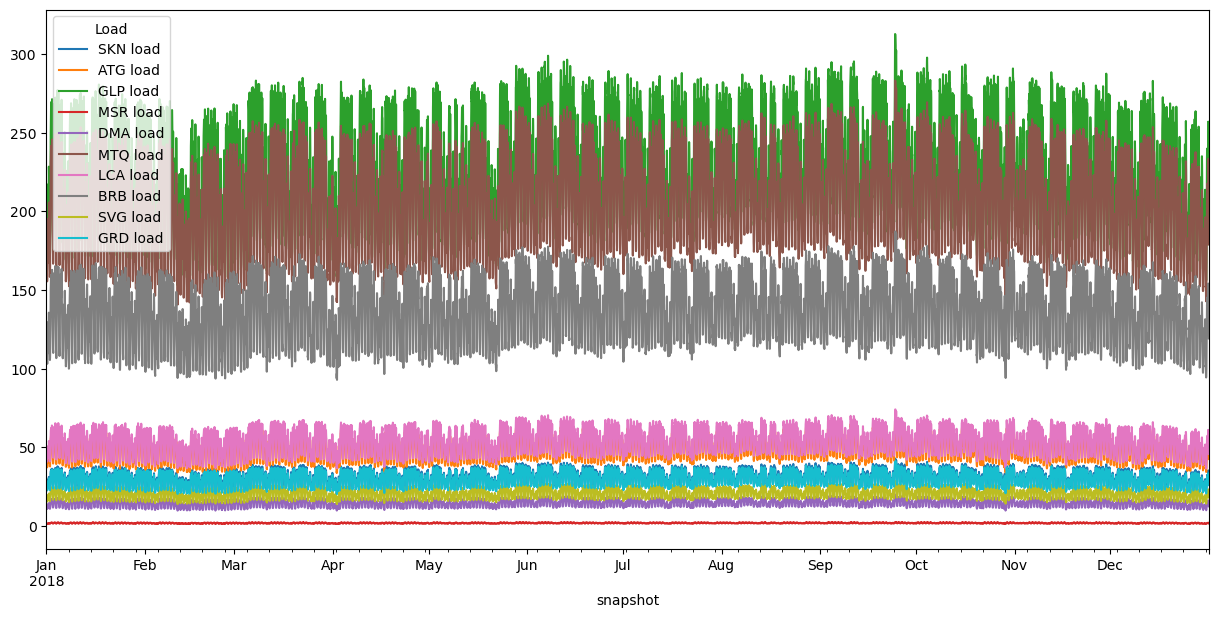

In [15]:
#print the load active power (P) consumption
network.loads_t.p.plot(figsize = (15,7))

<Axes: xlabel='snapshot'>

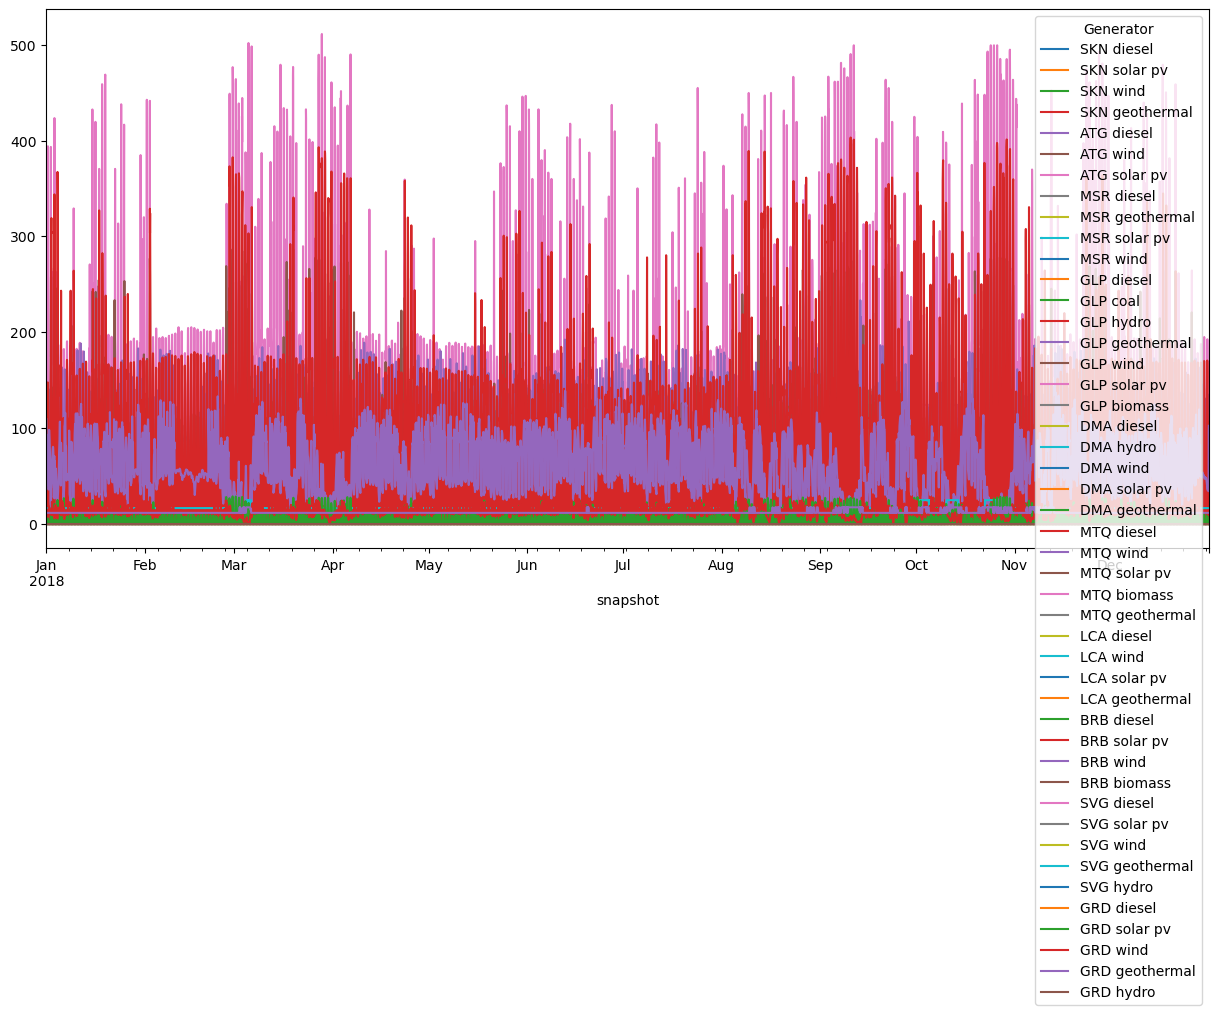

In [16]:
#print the generator active power (P) dispatch if desired
network.generators_t.p.plot(figsize = (15,7))
#network.generators.p_nom_opt

In [17]:
#start manipulation of results for capacities
df_cap=pd.DataFrame(network.generators.p_nom_opt)
df_cap = df_cap.reset_index()

In [18]:
#reshape dataframe for output capacities
df_cap.columns = ['name','Capacity']
new = df_cap["name"].str.split(" ", n = 1, expand = True)
df_cap["Technology"]= new[1]
df_cap['Country']= new[0]
df_cap.drop(columns =["name"], inplace = True)
df_cap= df_cap.pivot(index = 'Country',columns = 'Technology', values = 'Capacity')
df_cap

Technology,biomass,coal,diesel,geothermal,hydro,solar pv,wind
Country,,,,,,,
ATG,NaN,NaN,0.0,NaN,NaN,294.382021,28.888208
BRB,10.0,NaN,0.0,NaN,NaN,570.000000,150.000000
DMA,NaN,NaN,0.0,15.000000,6.6,-0.000000,-0.000000
GLP,10.0,-0.0,0.0,138.117549,15.0,654.589329,168.954501
GRD,NaN,NaN,0.0,19.343406,-0.0,36.885733,38.226805
LCA,NaN,NaN,0.0,60.000000,NaN,44.264691,75.500048
MSR,NaN,NaN,0.0,1.500000,NaN,4.866103,0.861501
MTQ,41.4,NaN,0.0,108.459808,NaN,362.584084,239.890144
SKN,NaN,NaN,0.0,55.597847,NaN,1.500000,2.200000


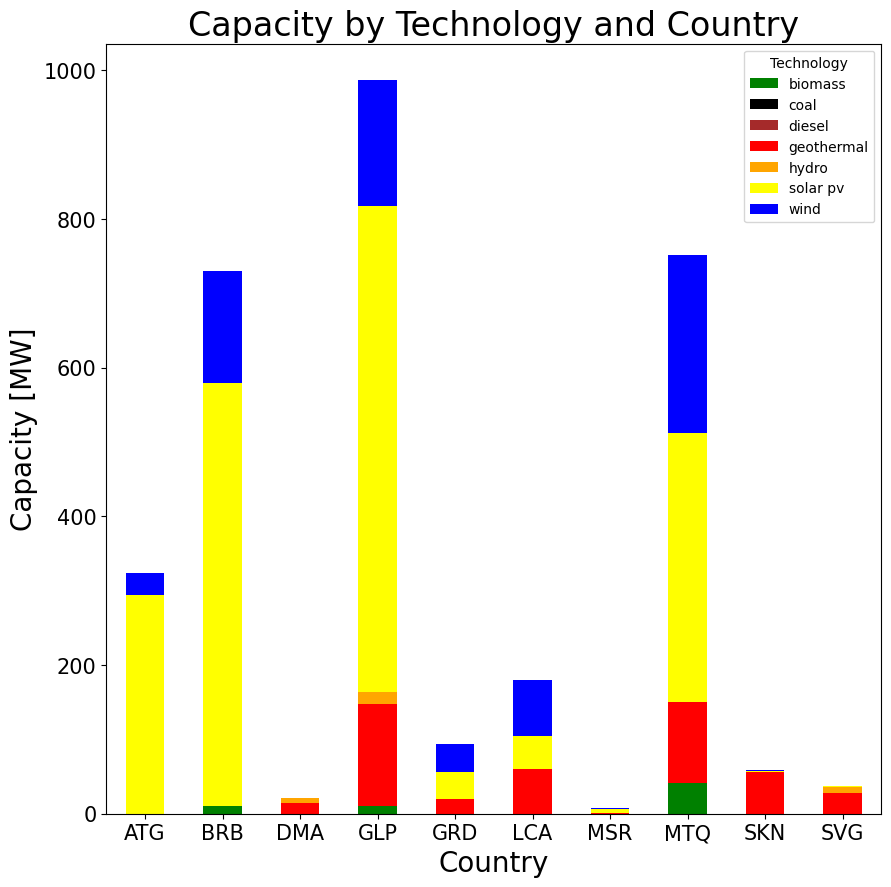

In [19]:
#plot capacity by country and technology
fig, axs = plt.subplots(figsize=(10, 10))        # Create an empty Matplotlib Figure and Axes
df_cap.plot(ax = axs,kind = 'bar', color=['green','black', 'brown', 'red', 'orange','yellow', 'blue'], rot=0,stacked = True)                  # Use pandas to put the area plot on the prepared Figure/Axes
axs.tick_params(axis='both', which='major', labelsize=15)
axs.set_title("Capacity by Technology and Country",fontsize=24)
axs.set_ylabel("Capacity [MW]",fontsize=20)          # Do any Matplotlib customization you like
axs.set_xlabel("Country",fontsize=20) 
fig.savefig(scenario+"capacity.png", bbox_inches='tight')  

In [20]:
#scale capacities to the maximum for each country
df_cap_scaled = df_cap.div(df_cap.sum(axis=1), axis=0)*100
df_cap_scaled

Technology,biomass,coal,diesel,geothermal,hydro,solar pv,wind
Country,,,,,,,
ATG,NaN,NaN,0.0,NaN,NaN,91.063759,8.936241
BRB,1.369863,NaN,0.0,NaN,NaN,78.082192,20.547945
DMA,NaN,NaN,0.0,69.444444,30.555556,-0.000000,-0.000000
GLP,1.013519,-0.0,0.0,13.998475,1.520278,66.343869,17.123859
GRD,NaN,NaN,0.0,20.478760,-0.000000,39.050727,40.470513
LCA,NaN,NaN,0.0,33.376957,NaN,24.623678,41.999364
MSR,NaN,NaN,0.0,20.753767,NaN,67.326643,11.919590
MTQ,5.502875,NaN,0.0,14.416443,NaN,48.194561,31.886121
SKN,NaN,NaN,0.0,93.760313,NaN,2.529603,3.710084


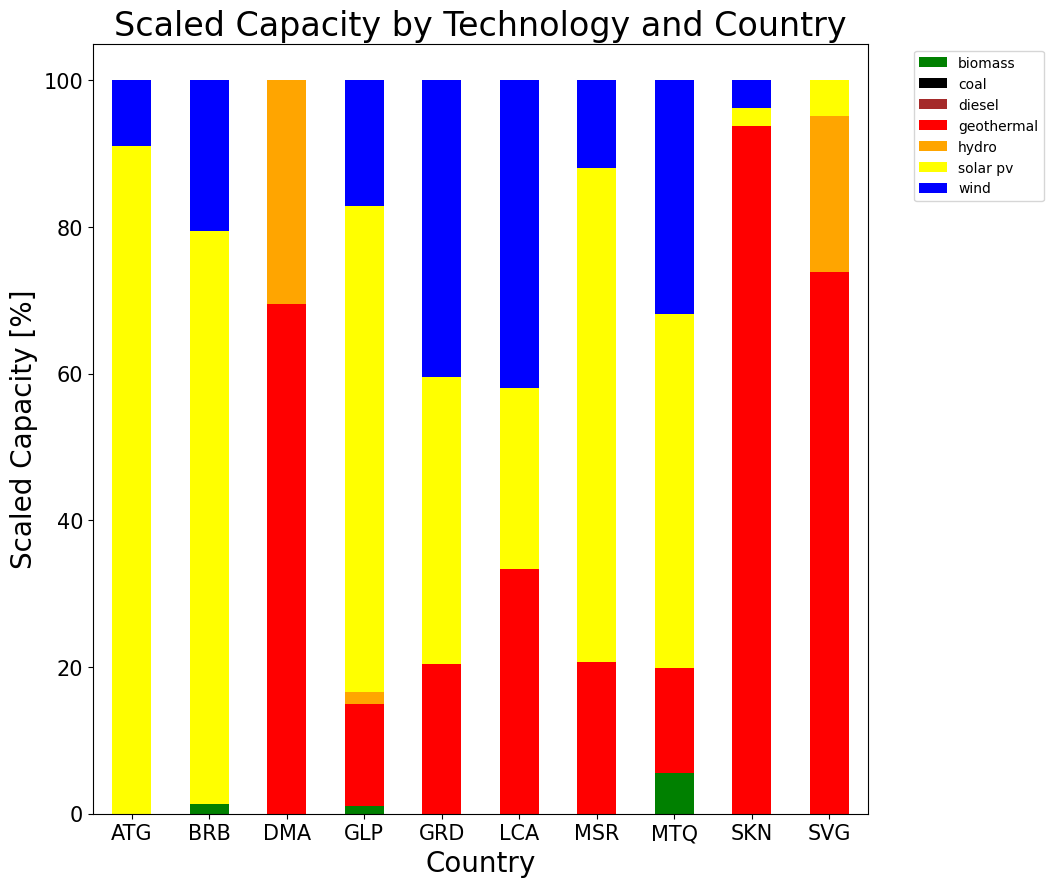

In [21]:
#plot scaled capacities by country and technology
fig, axs = plt.subplots(figsize=(10, 10))        # Create an empty Matplotlib Figure and Axes
df_cap_scaled.plot(ax = axs,kind = 'bar', color=['green','black', 'brown', 'red', 'orange','yellow', 'blue'], rot=0,stacked = True)                  # Use pandas to put the area plot on the prepared Figure/Axes
axs.tick_params(axis='both', which='major', labelsize=15)
axs.set_title("Scaled Capacity by Technology and Country",fontsize=24)
axs.set_ylabel("Scaled Capacity [%]",fontsize=20)          # Do any Matplotlib customization you like
axs.set_xlabel("Country",fontsize=20) 
axs.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
fig.savefig(scenario+"scaled_capacity.png", bbox_inches='tight')

In [22]:
#optimum storage unit capacity [MW]
network.storage_units.p_nom_opt

StorageUnit
ATG Storage     70.000000
BRB Storage    200.000000
DMA Storage     -0.000000
GLP Storage    320.000000
GRD Storage     45.000000
LCA Storage     75.000000
MSR Storage      2.306649
MTQ Storage    250.000000
SKN Storage     45.000000
SVG Storage     30.000000
Name: p_nom_opt, dtype: float64

In [23]:
#storage units energy capacity [MWh]
network.storage_units.p_nom_opt*network.storage_units.max_hours

StorageUnit
ATG Storage     420.000000
BRB Storage    1200.000000
DMA Storage      -0.000000
GLP Storage    1920.000000
GRD Storage     270.000000
LCA Storage     450.000000
MSR Storage      13.839894
MTQ Storage    1500.000000
SKN Storage     270.000000
SVG Storage     180.000000
dtype: float64

In [24]:
#print the capacities of the links
network.links.p_nom_opt

Link
SKN MSR link     0.000000
MSR ATG link     0.000000
ATG GLP link     0.000000
GLP DMA link     0.000000
DMA MTQ link     0.000000
MTQ LCA link     0.000000
LCA SVG link     0.000000
SVG GRD link     0.000000
SVG BRB link    15.266356
LCA BRB link    22.905394
SKN ATG link    24.251074
Name: p_nom_opt, dtype: float64

In [25]:
#sum up generator costs by country and technology
network.generators_t.p.sum()

Generator
SKN diesel             0.000000
SKN solar pv        1609.516501
SKN wind            7533.059840
SKN geothermal    298281.145726
ATG diesel             0.000000
ATG wind          103388.517351
ATG solar pv      299386.650583
MSR diesel             0.000000
MSR geothermal      8027.444470
MSR solar pv        5362.680238
MSR wind            3000.395292
GLP diesel             0.000000
GLP coal               0.000000
GLP hydro           5591.153263
GLP geothermal    733924.700493
GLP wind          580147.901876
GLP solar pv      682683.651963
GLP biomass          822.792405
DMA diesel             0.000000
DMA hydro          44743.700000
DMA wind               0.000000
DMA solar pv           0.000000
DMA geothermal     82737.200000
MTQ diesel             0.000000
MTQ wind          835319.117528
MTQ solar pv      384934.306298
MTQ biomass         7335.340551
MTQ geothermal    593484.535623
LCA diesel             0.000000
LCA wind          235639.473562
LCA solar pv       43298.37850

In [26]:
#calculate total generation for the region
(network.generators_t.p.sum()).sum()

6799810.609999999

In [27]:
#reshape dataframe for storage costs by country 
df_storage_cost = pd.DataFrame(network.storage_units.p_nom_opt*network.storage_units.capital_cost)
df_storage_cost.columns = ['storage_cost']
df_storage_cost = df_storage_cost.reset_index()
#df_storage_cost

In [28]:
#reshape storage costs dataframe
new = df_storage_cost["StorageUnit"].str.split(" ", n = 1, expand = True)
df_storage_cost["Tech"]= new[1]
df_storage_cost['Country']= new[0]
df_storage_cost.drop(columns =["StorageUnit"], inplace = True)
df_storage_cost= df_storage_cost.pivot(index = 'Country',columns = 'Tech', values = 'storage_cost')
#df_storage_cost 

In [29]:
#reshape dataframe for generator costs 
df_cost=pd.DataFrame((network.generators.p_nom_opt*network.generators.capital_cost)+(network.generators_t.p.sum()*network.generators.marginal_cost))
df_cost.columns = ['generator_cost']
df_cost = df_cost.reset_index()
#df_cost

In [30]:
#reshape dataframe for generator and storage costs
new1 = df_cost["Generator"].str.split(" ", n = 1, expand = True)
df_cost["Technology"]= new1[1]
df_cost['Country']= new1[0]
df_cost.drop(columns =["Generator"], inplace = True)
df_cost = df_cost.pivot(index = 'Country',columns = 'Technology', values = 'generator_cost')
#extracted_col = pd.DataFrame(df_storage_cost['storage_cost'])
#extracted_col
df_cost = df_cost.join(df_storage_cost['Storage'])
df_cost


,biomass,coal,diesel,geothermal,hydro,solar pv,wind,Storage
Country,,,,,,,,
ATG,NaN,NaN,0.0,NaN,NaN,2.266742e+07,2.484386e+06,6.314910e+06
BRB,3.675823e+06,NaN,0.0,NaN,NaN,4.389000e+07,1.290000e+07,1.804260e+07
DMA,NaN,NaN,0.0,1.274724e+07,1.477037e+06,0.000000e+00,0.000000e+00,-0.000000e+00
GLP,3.615191e+06,0.0,0.0,1.168164e+08,2.395912e+06,5.040338e+07,1.453009e+07,2.886816e+07
GRD,NaN,NaN,0.0,1.641996e+07,0.000000e+00,2.840201e+06,3.287505e+06,4.059585e+06
LCA,NaN,NaN,0.0,5.077012e+07,NaN,3.408381e+06,6.493004e+06,6.765975e+06
MSR,NaN,NaN,0.0,1.269799e+06,NaN,3.746899e+05,7.408906e+04,2.080897e+05
MTQ,1.551695e+07,NaN,0.0,9.207572e+07,NaN,2.791897e+07,2.063055e+07,2.255325e+07
SKN,NaN,NaN,0.0,4.708023e+07,NaN,1.155000e+05,1.892000e+05,4.059585e+06


In [31]:
#reshape dataframe for actual generation by country and technology (in GWh)
df_gen=pd.DataFrame(network.generators_t.p.sum()/1000)
df_gen = df_gen.reset_index()
df_gen.columns = ['name','Electricity']
new = df_gen["name"].str.split(" ", n = 1, expand = True)
df_gen["Technology"]= new[1]
df_gen['Country']= new[0]
df_gen.drop(columns =["name"], inplace = True)
df_gen= df_gen.pivot(index = 'Country',columns = 'Technology', values = 'Electricity')
df_gen

Technology,biomass,coal,diesel,geothermal,hydro,solar pv,wind
Country,,,,,,,
ATG,NaN,NaN,0.0,NaN,NaN,299.386651,103.388517
BRB,1.255881,NaN,0.0,NaN,NaN,566.578791,536.859125
DMA,NaN,NaN,0.0,82.737200,44.743700,0.000000,0.000000
GLP,0.822792,0.0,0.0,733.924700,5.591153,682.683652,580.147902
GRD,NaN,NaN,0.0,105.775365,0.000000,40.784837,117.458499
LCA,NaN,NaN,0.0,320.005964,NaN,43.298379,235.639474
MSR,NaN,NaN,0.0,8.027444,NaN,5.362680,3.000395
MTQ,7.335341,NaN,0.0,593.484536,NaN,384.934306,835.319118
SKN,NaN,NaN,0.0,298.281146,NaN,1.609517,7.533060


In [32]:
#reshape link costs dataframe
df_link_cost = pd.DataFrame(network.links.p_nom_opt*network.links.capital_cost)
df_link_cost.columns = ['link_cost']
df_link_cost = df_link_cost.reset_index()
#df_link_cost

In [33]:
#calculate total link costs
df_link_cost.link_cost.sum()


12512772.737697123

In [34]:
#calculate LCOE for each country separately but without transmission link costs
df_cost.sum(axis=1)/df_gen.sum(axis=1)/1000

Country
ATG     78.124756
BRB     71.068040
DMA    111.579703
GLP    108.143157
GRD    100.777890
LCA    112.593999
MSR    117.547680
MTQ     98.126442
SKN    167.340749
SVG    179.142240
dtype: float64

In [35]:
(df_gen.sum()).sum()

6799.8106099999995

In [36]:
(df_gen.sum(axis=1))

Country
ATG     402.775168
BRB    1104.693797
DMA     127.480900
GLP    2003.170200
GRD     264.018700
LCA     598.943816
MSR      16.390520
MTQ    1821.073300
SKN     307.423722
SVG     153.840487
dtype: float64

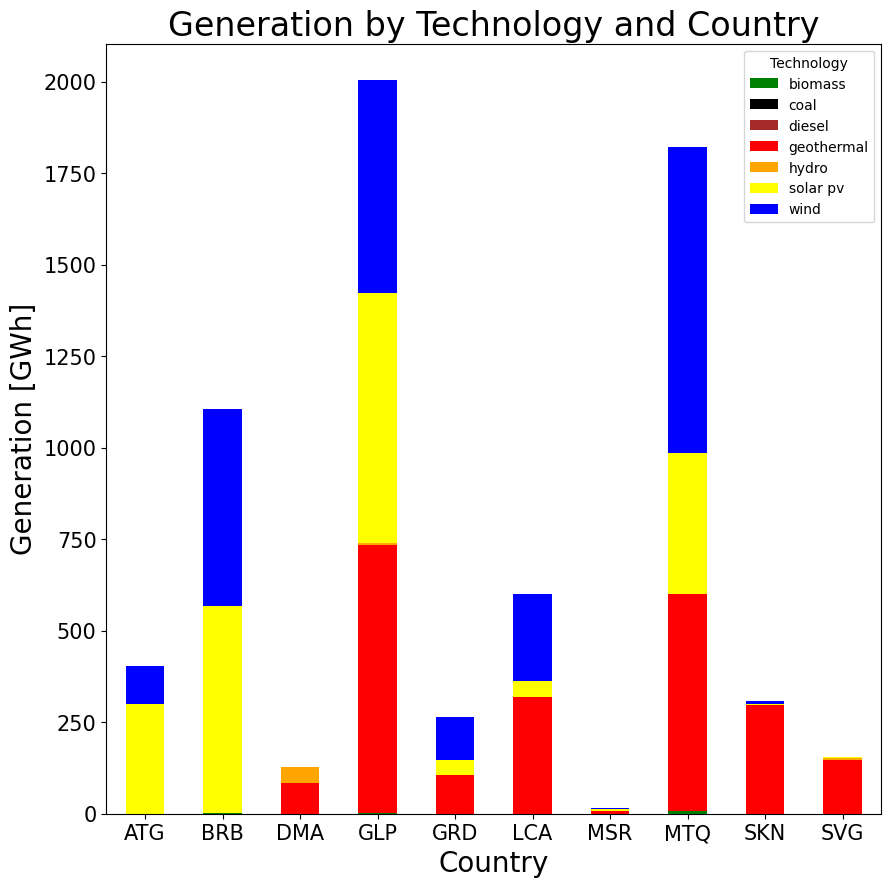

In [37]:
#plot the actual generation by country and technology [GWh]
fig, axs = plt.subplots(figsize=(10, 10))        # Create an empty Matplotlib Figure and Axes
df_gen.plot(ax = axs,kind = 'bar', color=['green','black', 'brown', 'red', 'orange','yellow', 'blue'], rot=0,stacked = True)                  # Use pandas to put the area plot on the prepared Figure/Axes
axs.tick_params(axis='both', which='major', labelsize=15)
axs.set_title("Generation by Technology and Country",fontsize=24)
axs.set_ylabel("Generation [GWh]",fontsize=20)          # Do any Matplotlib customization you like
axs.set_xlabel("Country",fontsize=20) 
fig.savefig(scenario+"generation.png", bbox_inches='tight') 

In [38]:
#scaled the generation output by country and technology
df_gen_scaled = df_gen.div(df_gen.sum(axis=1), axis=0)*100

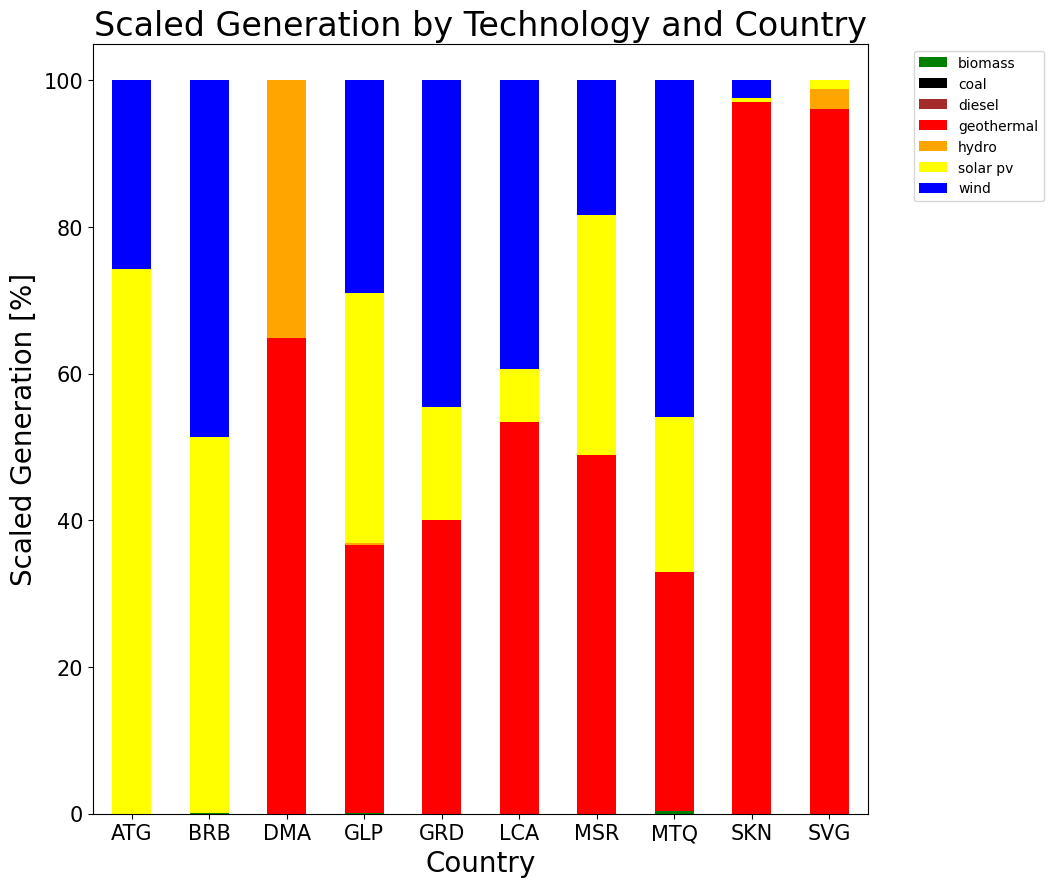

In [39]:
#plot the scaled output by technology and country
fig, axs = plt.subplots(figsize=(10, 10))        # Create an empty Matplotlib Figure and Axes
df_gen_scaled.plot(ax = axs,kind = 'bar', color=['green','black', 'brown', 'red', 'orange','yellow', 'blue'], rot=0,stacked = True)                  # Use pandas to put the area plot on the prepared Figure/Axes
axs.tick_params(axis='both', which='major', labelsize=15)
axs.set_title("Scaled Generation by Technology and Country",fontsize=24)
axs.set_ylabel("Scaled Generation [%]",fontsize=20)          # Do any Matplotlib customization you like
axs.set_xlabel("Country",fontsize=20) 
axs.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
fig.savefig(scenario+"scaled_generation.png", bbox_inches='tight') 

In [40]:
#network.generators_t.p.sum()/(network.generators_t.p.sum()).sum()

In [41]:
#calculate capacity factors by country and technology
#network.generators_t.p.sum()/(network.generators.p_nom_opt*8760)

In [42]:
#calculate regional LCOE
((network.generators.p_nom_opt*network.generators.capital_cost).sum()+(network.generators_t.p.sum()*network.generators.marginal_cost).sum()+(network.storage_units.p_nom_opt*network.storage_units.capital_cost).sum()+df_link_cost.link_cost.sum()).sum()/(network.loads_t.p_set.sum()).sum()

103.97525191217508

In [43]:
((network.generators.p_nom_opt*network.generators.capital_cost).sum()+(network.generators_t.p.sum()*network.generators.marginal_cost).sum()+(network.storage_units.p_nom_opt*network.storage_units.capital_cost).sum())/network.loads_t.p_set.sum()

Load
SKN load     2542.250542
MSR load    42372.008234
ATG load     1589.184801
GLP load      346.700070
DMA load     5447.869041
MTQ load      381.368091
LCA load     1466.923218
SVG load     3813.486790
GRD load     2630.492645
BRB load      577.823844
dtype: float64

<Axes: xlabel='snapshot'>

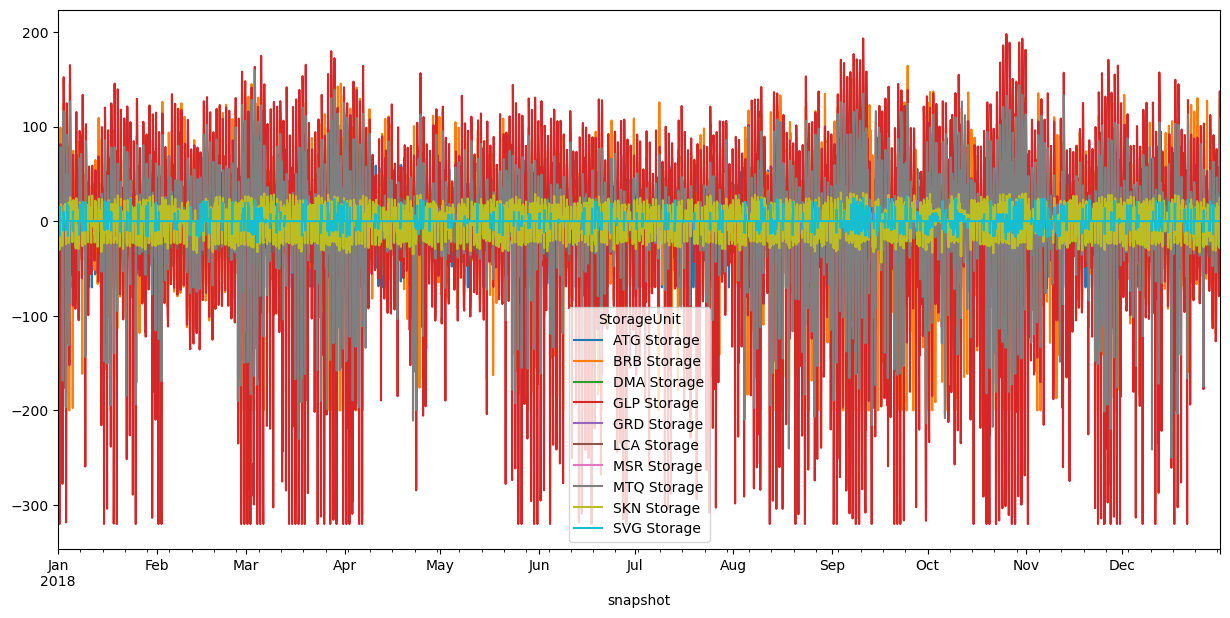

In [44]:
#print storage units
network.storage_units_t.p.plot(figsize = (15,7))



<Axes: xlabel='snapshot'>

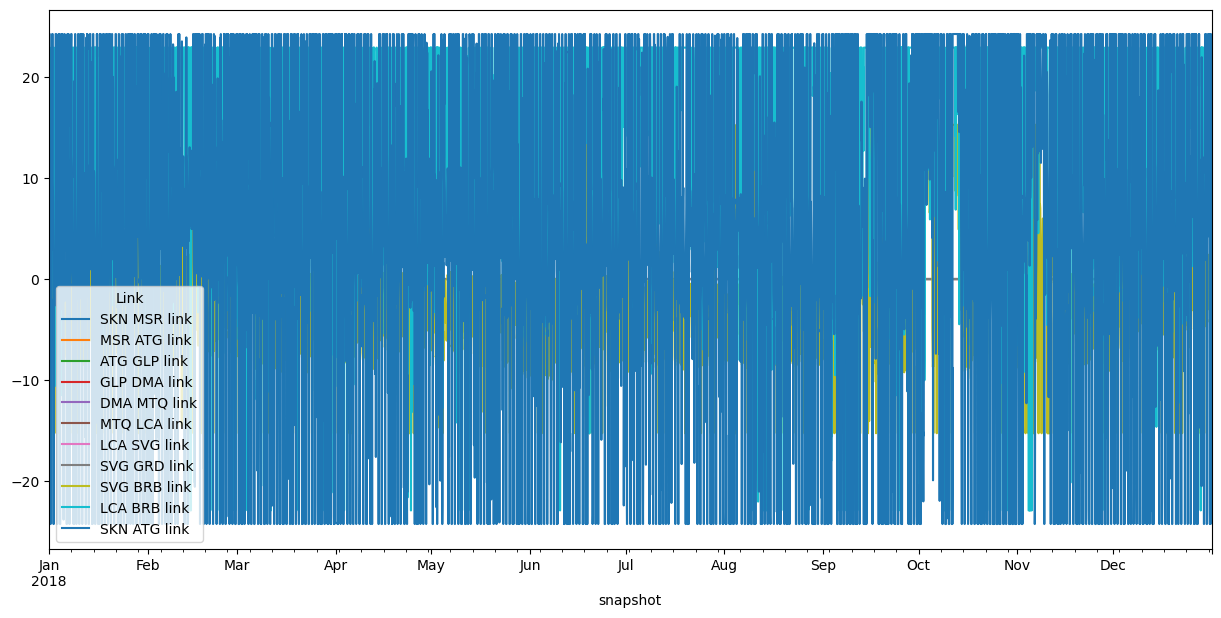

In [45]:
#print link action
network.links_t.p0.plot(figsize = (15,7))